##TASK A: SCRAPE

In [ ]:
%pip install selenium pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.6 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 499 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 11.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

options = Options()
options.add_argument("--headless=new")
driver = webdriver.Chrome(options=options)

search_url = "https://www.gofundme.com/s?q=cancer"
driver.get(search_url)

wait = WebDriverWait(driver, 20)

# Keep clicking "Show More" until we have 1200 links or no more button
links = set()
while len(links) < 1200:
    campaigns = driver.find_elements(By.CSS_SELECTOR, "a[href*='/f/']")
    for c in campaigns:
        href = c.get_attribute("href")
        if href and "/f/" in href:
            links.add(href)
        if len(links) >= 1200:
            break

    print(f"Currently collected: {len(links)} links")

    try:
        show_more = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "button[data-element-id='btn_show_more']"))
        )
        driver.execute_script("arguments[0].click();", show_more)
        time.sleep(2)
    except:
        print("⚠️ No more 'Show more' button found.")
        break

links = list(links)
print(f"\nFound {len(links)} campaign links in total")

data = []

# ========== scrape each campaign ==========
for i, url in enumerate(links, start=1):
    driver.get(url)
    time.sleep(2)

    title, description, amount, goal, created, cover_image = None, None, None, None, None, None

    try:
        # JSON first
        script = driver.find_element(By.ID, "__NEXT_DATA__").get_attribute("innerHTML")
        js = json.loads(script)
        page_props = js["props"]["pageProps"]
        fundraiser = page_props.get("fundraiser") or page_props.get("fundraiserDto")

        if fundraiser:
            title = fundraiser.get("fundName")
            description = fundraiser.get("description")
            amount = fundraiser.get("currentAmount")
            goal = fundraiser.get("goalAmount")
            created = fundraiser.get("createdAt")
            if fundraiser.get("media"):
                cover_image = fundraiser["media"][0]["url"]

    except Exception as e:
        print(f"JSON failed at {url}: {e}")

    try:
        if not title:
            title = driver.find_element(By.TAG_NAME, "h1").text

        if not description:
            try:
                description = driver.find_element(
                    By.CSS_SELECTOR, "div[class*='campaign-description_content']"
                ).text
            except:
                description = None

        if not cover_image:
            try:
                cover_image = driver.find_element(
                    By.CSS_SELECTOR, "img[class*='hero-media-viewer_coverImage']"
                ).get_attribute("src")
            except:
                cover_image = None

        if not created:
            try:
                created = driver.find_element(
                    By.CSS_SELECTOR, "span.m-campaign-byline-created"
                ).text
            except:
                created = None

        if not amount or not goal:
            try:
                amount_block = driver.find_element(
                    By.XPATH, "//div[contains(@class,'donation-overview')]//h2"
                ).text
                parts = amount_block.split("raised of")
                amount = parts[0].strip()
                goal = parts[1].strip() if len(parts) > 1 else None
            except:
                amount, goal = None, None

    except Exception as e:
        print(f"HTML fallback failed at {url}: {e}")

    campaign_data = {
        "title": title,
        "description": description,
        "amount": amount,
        "goal": goal,
        "created": created,
        "cover_image": cover_image,
        "url": url
    }
    data.append(campaign_data)
    print(f"[{i}/{len(links)}] Scraped: {title}")

print(f"\nFinished scraping {len(data)} campaigns.")


Currently collected: 48 links
Currently collected: 96 links
Currently collected: 144 links
Currently collected: 192 links
Currently collected: 240 links
Currently collected: 288 links
Currently collected: 336 links
Currently collected: 384 links
Currently collected: 432 links
Currently collected: 480 links
Currently collected: 528 links
Currently collected: 576 links
Currently collected: 624 links
Currently collected: 672 links
Currently collected: 720 links
Currently collected: 768 links
Currently collected: 816 links
Currently collected: 864 links
Currently collected: 912 links
Currently collected: 960 links
Currently collected: 1000 links
⚠️ No more 'Show more' button found.

Found 1000 campaign links in total
[1/1000] Scraped: Help Baby Jenson Fight a Rare Brain Cancer
[2/1000] Scraped: Dennis’s Fight Against Stage 4 Esophageal Cancer
[3/1000] Scraped: Support Daniel DeMeza's Fight Against Cancer
[4/1000] Scraped: Stand with Alexis Gleason in Her Fight Against Brain Cancer
[5/1000]

In [ ]:
import pandas as pd

df = pd.DataFrame(data)
df.to_csv("campaigns.csv", index=False, quoting=1)

##TASK B: LABEL IMAGES

In [1]:
%pip install google-generativeai

In [ ]:
import pandas as pd
import os
from google.cloud import vision

# 1. Setup service account key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/gracelin/Desktop/Synced Air/fall 25/4_unstructured/assignment/assignment_3/gen-lang-client-0003990277-c8504c9e2ebf.json"

# 2. Initialize the Vision client
client = vision.ImageAnnotatorClient()

# 3. Function to label one image
def label_image(image_url, idx, total):
    if not isinstance(image_url, str) or image_url.strip() == "" or image_url == "nan":
        print(f"\n⚠️ Skipped {idx+1}/{total} (no image URL)")
        return "No image URL"

    try:
        image = vision.Image()
        image.source.image_uri = image_url

        # Main label detection
        response = client.label_detection(image=image)
        labels = [label.description for label in response.label_annotations]

        # If no labels (e.g., just text banners), fallback to OCR
        if not labels:
            text_response = client.text_detection(image=image)
            texts = [t.description for t in text_response.text_annotations]
            if texts:
                labels = ["TEXT: " + texts[0][:100]]

        result = ", ".join(labels) if labels else "No labels"

    except Exception as e:
        result = f"Error: {e}"

    # Print progress + preview
    print(f"\n✅ Processed {idx+1}/{total}")
    print(f"   URL: {image_url[:80]}...")
    print(f"   Labels: {result}\n")

    return result

# 4. Load campaigns
df = pd.read_csv("campaigns.csv", quoting=1)

# 5. Loop with progress tracking + output preview
total = len(df)
labels = []
for i, url in enumerate(df["cover_image"]):
    label = label_image(url, i, total)
    labels.append(label)
    time.sleep(0.2)  # avoid quota/rate-limit

df["image_labels"] = labels

In [ ]:
df.to_csv("campaigns_with_labels.csv", index=False, quoting=1)

##TASK C: CREATE BINARY COLUMN

In [16]:
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
# Load in the data
url = "https://raw.githubusercontent.com/graccelinn/Unstructured_Assignment_3/main/campaigns_with_labels_animals.csv"
campaigns = pd.read_csv(url)
campaigns.head()

,title,description,amount,goal,created,cover_image,url,image_labels
0,2nd Annual Massage fundraiser for Homeward Ani...,Last years fundraiser for the Homeward Animal ...,"$1,000",1K,"August 20th, 2025",https://images.gofundme.com/3hguyHJimIvbn6Cr6m...,https://www.gofundme.com/f/2nd-annual-massage-...,"Dog, Vertebrate, Carnivores, Snout, Working an..."
1,GCFA: Fundraiser for High Shelter Census and H...,CALLING ALL ANIMAL LOVERS & SHELTER SUPPORTERS...,"$1,495",5K,"July 16th, 2025",https://images.gofundme.com/bSnOcdg33RMZfoYWlt...,https://www.gofundme.com/f/help-gcfa-ferrets-b...,"Snout, Advertising, Photo caption, Rodent, Fur..."
2,Help for Balkanabat Dog Haven,"My name is Dmitry, I live in Balkanabat, Turkm...",$174,13K,"September 25th, 2025",https://images.gofundme.com/ca0ib-jbVfhNWaslYL...,https://www.gofundme.com/f/help-for-balkanabat...,"Dog, Carnivores, Street dog, Snout, Working an..."
3,Support Daniel's Eagle Scout Project for the A...,"Hi, my name is Daniel Watrous. I am a Life Sco...","$1,500",1.5K,"April 19th, 2024",https://images.gofundme.com/H-EKZ8nalH3eeYBBBK...,https://www.gofundme.com/f/support-daniels-eag...,"Facial expression, Smile, Scout, Carnivores, F..."
4,Marathon Madness for a Animal Shelter & Dement...,"Hey, I’m Emma ☺️, and I’ve made the (probably ...",£825,500,"September 19th, 2024",https://images.gofundme.com/26ICpSFlt_932tMOW7...,https://www.gofundme.com/f/marathon-madness-fo...,"Body of water, Coast, Sea, Coastal and oceanic..."


In [7]:
# Clean the data frame

# --- 1. Define exchange rates (approx as of 2025-10-02) ---
rates = {
    "USD": 1.0,
    "GBP": 1.25,   # 1 GBP ≈ 1.25 USD
    "EUR": 1.05,   # 1 EUR ≈ 1.05 USD
    "NOK": 0.095   # 1 NOK ≈ 0.095 USD
}

# --- 2. Detect currency symbols robustly ---
def detect_currency(x):
    if pd.isna(x):
        return "USD"
    x = str(x).strip()
    if x.startswith("$"):
        return "USD"
    elif x.startswith("£") or x.startswith("¬£"):
        return "GBP"
    elif x.startswith("€") or x.startswith("‚Ç¨"):
        return "EUR"
    elif x.lower().startswith("kr"):
        return "NOK"
    return "USD"

campaigns["currency"] = campaigns["amount"].apply(detect_currency)

# --- 3. Clean 'amount' to numeric USD ---
def clean_amount(x, currency):
    if pd.isna(x):
        return np.nan
    # keep digits and decimal only
    val = re.sub(r"[^\d.]", "", str(x))
    if val == "":
        return np.nan
    try:
        val = float(val.replace(",", ""))
    except:
        return np.nan
    return val * rates[currency]

campaigns["amount_usd"] = campaigns.apply(lambda row: clean_amount(row["amount"], row["currency"]), axis=1)

# --- 4. Clean 'goal' to numeric USD ---
def clean_goal(x, currency):
    if pd.isna(x):
        return np.nan
    val = str(x).upper().replace(",", "").strip()
    multiplier = 1
    if val.endswith("K"):
        multiplier = 1000
        val = val[:-1]
    elif val.endswith("M"):
        multiplier = 1_000_000
        val = val[:-1]
    val = re.sub(r"[^\d.]", "", val)
    if val == "":
        return np.nan
    try:
        val = float(val)
    except:
        return np.nan
    return val * multiplier * rates[currency]

campaigns["goal_usd"] = campaigns.apply(lambda row: clean_goal(row["goal"], row["currency"]), axis=1)

# --- 5. Clean 'created' column ---
reference_date = datetime(2025, 10, 2)  # scrape date

def clean_created(x):
    x = str(x).strip()

    # Handle relative dates (e.g. "2 d ago")
    if "d ago" in x:
        days = int(re.search(r"(\d+)", x).group(1))
        return days

    # Remove ordinal suffixes (1st → 1, 2nd → 2, etc.)
    x = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', x)

    # Try parsing with pandas datetime
    dt = pd.to_datetime(x, errors="coerce")
    days = (reference_date - dt).days
    return days

campaigns["duration_days"] = campaigns["created"].apply(clean_created)

# --- Final cleaned dataframe ---
cleaned_df = campaigns[["title", "description", "amount_usd", "goal_usd", "duration_days", "cover_image", "url", "image_labels"]]
cleaned_df.head()

,title,description,amount_usd,goal_usd,duration_days,cover_image,url,image_labels
0,2nd Annual Massage fundraiser for Homeward Ani...,Last years fundraiser for the Homeward Animal ...,1000.00,1000.0,43.0,https://images.gofundme.com/3hguyHJimIvbn6Cr6m...,https://www.gofundme.com/f/2nd-annual-massage-...,"Dog, Vertebrate, Carnivores, Snout, Working an..."
1,GCFA: Fundraiser for High Shelter Census and H...,CALLING ALL ANIMAL LOVERS & SHELTER SUPPORTERS...,1495.00,5000.0,78.0,https://images.gofundme.com/bSnOcdg33RMZfoYWlt...,https://www.gofundme.com/f/help-gcfa-ferrets-b...,"Snout, Advertising, Photo caption, Rodent, Fur..."
2,Help for Balkanabat Dog Haven,"My name is Dmitry, I live in Balkanabat, Turkm...",174.00,13000.0,7.0,https://images.gofundme.com/ca0ib-jbVfhNWaslYL...,https://www.gofundme.com/f/help-for-balkanabat...,"Dog, Carnivores, Street dog, Snout, Working an..."
3,Support Daniel's Eagle Scout Project for the A...,"Hi, my name is Daniel Watrous. I am a Life Sco...",1500.00,1500.0,531.0,https://images.gofundme.com/H-EKZ8nalH3eeYBBBK...,https://www.gofundme.com/f/support-daniels-eag...,"Facial expression, Smile, Scout, Carnivores, F..."
4,Marathon Madness for a Animal Shelter & Dement...,"Hey, I’m Emma ☺️, and I’ve made the (probably ...",1031.25,625.0,378.0,https://images.gofundme.com/26ICpSFlt_932tMOW7...,https://www.gofundme.com/f/marathon-madness-fo...,"Body of water, Coast, Sea, Coastal and oceanic..."


In [8]:
# Create binary column

# Compute median
median_value = cleaned_df["amount_usd"].median()

# Create binary column (1 = high money, 0 = low money)
cleaned_df["binary"] = (cleaned_df["amount_usd"] >= median_value).astype(int)

cleaned_df[["amount_usd", "binary"]].head()

/tmp/ipython-input-2557235179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["binary"] = (cleaned_df["amount_usd"] >= median_value).astype(int)


,amount_usd,binary
0,1000.00,0
1,1495.00,1
2,174.00,0
3,1500.00,1
4,1031.25,0


##TASK D: LOGISTIC REGRESSION

In [9]:
campaigns_file = cleaned_df.copy()
campaigns_file = campaigns_file.dropna(subset=["duration_days"])
campaigns_file.head()

,title,description,amount_usd,goal_usd,duration_days,cover_image,url,image_labels,binary
0,2nd Annual Massage fundraiser for Homeward Ani...,Last years fundraiser for the Homeward Animal ...,1000.00,1000.0,43.0,https://images.gofundme.com/3hguyHJimIvbn6Cr6m...,https://www.gofundme.com/f/2nd-annual-massage-...,"Dog, Vertebrate, Carnivores, Snout, Working an...",0
1,GCFA: Fundraiser for High Shelter Census and H...,CALLING ALL ANIMAL LOVERS & SHELTER SUPPORTERS...,1495.00,5000.0,78.0,https://images.gofundme.com/bSnOcdg33RMZfoYWlt...,https://www.gofundme.com/f/help-gcfa-ferrets-b...,"Snout, Advertising, Photo caption, Rodent, Fur...",1
2,Help for Balkanabat Dog Haven,"My name is Dmitry, I live in Balkanabat, Turkm...",174.00,13000.0,7.0,https://images.gofundme.com/ca0ib-jbVfhNWaslYL...,https://www.gofundme.com/f/help-for-balkanabat...,"Dog, Carnivores, Street dog, Snout, Working an...",0
3,Support Daniel's Eagle Scout Project for the A...,"Hi, my name is Daniel Watrous. I am a Life Sco...",1500.00,1500.0,531.0,https://images.gofundme.com/H-EKZ8nalH3eeYBBBK...,https://www.gofundme.com/f/support-daniels-eag...,"Facial expression, Smile, Scout, Carnivores, F...",1
4,Marathon Madness for a Animal Shelter & Dement...,"Hey, I’m Emma ☺️, and I’ve made the (probably ...",1031.25,625.0,378.0,https://images.gofundme.com/26ICpSFlt_932tMOW7...,https://www.gofundme.com/f/marathon-madness-fo...,"Body of water, Coast, Sea, Coastal and oceanic...",0


In [10]:
campaigns_file.to_csv("campaigns_file.csv", index=False)

In [11]:
# Feature Engineering
def prepare_features(text_column):
    vectorizer = CountVectorizer(max_features=1000)
    X_text = vectorizer.fit_transform(campaigns_file[text_column].fillna("")).toarray()
    X_duration = campaigns_file["duration_days"].values.reshape(-1, 1)
    return np.hstack((X_text, X_duration))

# Prepare feature sets
X_labels = prepare_features("image_labels")
X_desc = prepare_features("description")

# Combine both BoW matrices + duration
X_combined = np.hstack((X_labels[:, :-1], X_desc[:, :-1], campaigns_file["duration_days"].values.reshape(-1, 1)))
y = campaigns_file["binary"]

In [12]:
# Train & Evaluate Models
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    return cm, acc

# Model 1: Image Labels + Duration
cm_labels, acc_labels = train_and_evaluate(X_labels, y)

# Model 2: Description Text + Duration
cm_desc, acc_desc = train_and_evaluate(X_desc, y)

# Model 3: Combined Features
cm_combined, acc_combined = train_and_evaluate(X_combined, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

###Display Results

In [13]:
print("Model 1: Image Labels + Duration")
print("Confusion Matrix:\n", cm_labels)
print("Accuracy:", round(acc_labels * 100, 2), "%\n")

print("Model 2: Description Text + Duration")
print("Confusion Matrix:\n", cm_desc)
print("Accuracy:", round(acc_desc * 100, 2), "%\n")

print("Model 3: Combined Image Labels and Description + Duration")
print("Confusion Matrix:\n", cm_combined)
print("Accuracy:", round(acc_combined * 100, 2), "%")

Model 1: Image Labels + Duration
Confusion Matrix:
 [[106  15]
 [ 32  45]]
Accuracy: 76.26 %

Model 2: Description Text + Duration
Confusion Matrix:
 [[105  16]
 [ 21  56]]
Accuracy: 81.31 %

Model 3: Combined Image Labels and Description + Duration
Confusion Matrix:
 [[106  15]
 [ 23  54]]
Accuracy: 80.81 %


In [14]:
# Load dataset
df1 = campaigns_file.copy()

# Prepare BoW features for description
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_desc = vectorizer.fit_transform(df1["description"].fillna("")).toarray()
y = df1["binary"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_desc, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
 [[100  21]
 [ 38  39]]
Accuracy: 70.20%


### Conclusion
Combining Image + Text provides a richer feature set, allowing the model to leverage both visual appeal and narrative strength.
Adding duration accounts for time-based exposure, which influences fundraising success. After trying Description without the duration, we received 55.96% of accuracy.

Visual + Duration content is moderately predictive (63.21%).
Text + Duration performs slightly worse (60.1%).
Combining both improves accuracy to 67.88%, confirming that multimodal features (text + image) are effective for predicting campaign success.

##TASK E:

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import statsmodels.api as sm

In [18]:
# Load in the data
url = "https://raw.githubusercontent.com/graccelinn/Unstructured_Assignment_3/main/campaigns_file.csv"
campaigns_file = pd.read_csv(url)
campaigns_file.head()

,title,description,amount_usd,goal_usd,duration_days,cover_image,url,image_labels,binary
0,2nd Annual Massage fundraiser for Homeward Ani...,Last years fundraiser for the Homeward Animal ...,1000.00,1000.0,43.0,https://images.gofundme.com/3hguyHJimIvbn6Cr6m...,https://www.gofundme.com/f/2nd-annual-massage-...,"Dog, Vertebrate, Carnivores, Snout, Working an...",0
1,GCFA: Fundraiser for High Shelter Census and H...,CALLING ALL ANIMAL LOVERS & SHELTER SUPPORTERS...,1495.00,5000.0,78.0,https://images.gofundme.com/bSnOcdg33RMZfoYWlt...,https://www.gofundme.com/f/help-gcfa-ferrets-b...,"Snout, Advertising, Photo caption, Rodent, Fur...",1
2,Help for Balkanabat Dog Haven,"My name is Dmitry, I live in Balkanabat, Turkm...",174.00,13000.0,7.0,https://images.gofundme.com/ca0ib-jbVfhNWaslYL...,https://www.gofundme.com/f/help-for-balkanabat...,"Dog, Carnivores, Street dog, Snout, Working an...",0
3,Support Daniel's Eagle Scout Project for the A...,"Hi, my name is Daniel Watrous. I am a Life Sco...",1500.00,1500.0,531.0,https://images.gofundme.com/H-EKZ8nalH3eeYBBBK...,https://www.gofundme.com/f/support-daniels-eag...,"Facial expression, Smile, Scout, Carnivores, F...",1
4,Marathon Madness for a Animal Shelter & Dement...,"Hey, I’m Emma ☺️, and I’ve made the (probably ...",1031.25,625.0,378.0,https://images.gofundme.com/26ICpSFlt_932tMOW7...,https://www.gofundme.com/f/marathon-madness-fo...,"Body of water, Coast, Sea, Coastal and oceanic...",0


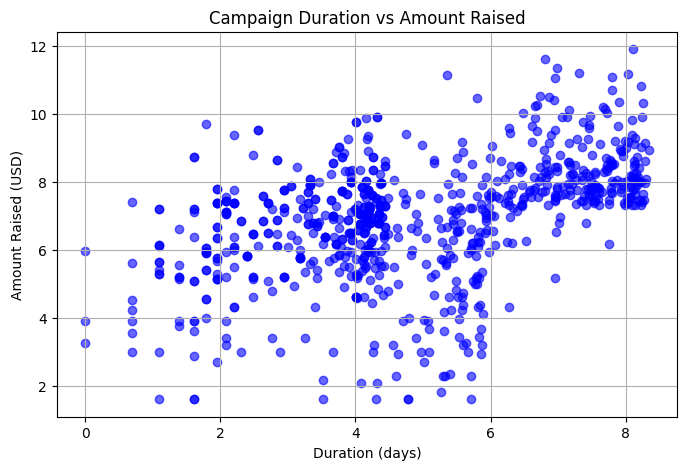

In [20]:
# exploratory visualization

plt.figure(figsize=(8, 5))
plt.scatter(np.log(campaigns_file["duration_days"]), np.log(campaigns_file["amount_usd"]), alpha=0.6, color="blue")
plt.xlabel("Duration (days)")
plt.ylabel("Amount Raised (USD)")
plt.title("Campaign Duration vs Amount Raised")
plt.grid(True)
plt.show()


Before topic modeling, create 1000x1000 matrix of words from images and calculate cosine similarty for each. then select 200 images with the lowest similarity in order to have images that are distinct and to get clearer separation from topic modeling

In [21]:
# Step 1: Build vocabulary and create word count matrix
vectorizer = CountVectorizer(token_pattern=r'[^,;|\n]+')
X = vectorizer.fit_transform(campaigns_file['image_labels'].str.lower())

# Step 2: Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Step 3: Calculate average similarity for each image (excluding self-similarity)
np.fill_diagonal(similarity_matrix, 0)
avg_similarity = similarity_matrix.mean(axis=1)

# Step 4: Select 200 images with lowest similarity
distinct_indices = np.argsort(avg_similarity)[:200]
distinct_images = campaigns_file.iloc[distinct_indices].copy()
distinct_images['avg_similarity'] = avg_similarity[distinct_indices]

print(f"Selected {len(distinct_images)} most distinct images")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"\nTop 10 most distinct:")
print(distinct_images[['image_labels', 'avg_similarity']].head(10))

Selected 200 most distinct images
Vocabulary size: 944

Top 10 most distinct:
                                          image_labels  avg_similarity
852                                           Graphics        0.000000
206                                         TEXT: ices        0.000000
126                                             Silver        0.000000
109  TEXT: MUTT STRUTT\nIn Memory of\nANN LEWIS\nJo...        0.000000
539                          Night, Darkness, Midnight        0.000000
946                                  Building material        0.000000
596                                            Baggage        0.000000
170                      TEXT: ARF\nHEAVEN FOR ANIMALS        0.000000
473  High-rise building, Metropolis, Tower, Condomi...        0.000143
889                 Palm trees, California palm, Waste        0.000194


In [22]:
# select whether you want to use all 1000 images (campaigns_file) or the 200 most unique images (distinct_images):
df = campaigns_file.copy()

In [23]:
# Concatenate description and image_labels
df["text_combined"] = df["description"].fillna("") + " " + df["image_labels"].fillna("")

# Create Bag-of-Words
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df["image_labels"].fillna(""))

# Fit LDA with n topics
n = 5
lda = LatentDirichletAllocation(n_components=n, random_state=42)
lda.fit(X)

# Get feature names (words)
words = vectorizer.get_feature_names_out()

# 1️⃣ Topic-word probabilities (reshape so each row = word)
topic_word_probs = lda.components_.T  # transpose so words are rows
topic_word_probs = topic_word_probs / topic_word_probs.sum(axis=0)  # normalize to probabilities

lda_topic_word_probabilities = pd.DataFrame(topic_word_probs, index=words, columns=[f"Topic_{i}" for i in range(1, n+1)])
lda_topic_word_probabilities.index.name = "word"
print("Topic-word probabilities (one word per row):")
print(lda_topic_word_probabilities.head())

# 2️⃣ Document-topic percentages with index and title
doc_topic_df = pd.DataFrame(lda.transform(X), columns=[f"Topic_{i}" for i in range(1, n+1)])
doc_topic_df.insert(0, "duration_days", df["duration_days"])    # add duration days as a column
doc_topic_df.insert(0, "amount_usd", df["amount_usd"])          # add amount donated as a column
doc_topic_df.insert(0, "title", df["title"])                    # add title as a column
doc_topic_df.insert(0, "index", df.index)                       # add original index as a column

lda_document_topic_percentages = doc_topic_df
print("\nDocument-topic percentages with index and title:")
print(lda_document_topic_percentages.head())

# Optional: save to CSV
lda_topic_word_probabilities.to_csv("lda_topic_word_probabilities.csv")
lda_document_topic_percentages.to_csv("lda_document_topic_percentages.csv", index=False)


Topic-word probabilities (one word per row):
                  Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
word                                                             
3d               0.001136  0.000117  0.000127  0.000032  0.000117
academic         0.001136  0.000117  0.000127  0.000032  0.000117
accipitridae     0.000189  0.000698  0.000130  0.000032  0.000118
accipitriformes  0.000189  0.000698  0.000130  0.000032  0.000118
active           0.003030  0.000117  0.000127  0.000032  0.000117

Document-topic percentages with index and title:
   index                                              title  amount_usd  \
0      0  2nd Annual Massage fundraiser for Homeward Ani...     1000.00   
1      1  GCFA: Fundraiser for High Shelter Census and H...     1495.00   
2      2                      Help for Balkanabat Dog Haven      174.00   
3      3  Support Daniel's Eagle Scout Project for the A...     1500.00   
4      4  Marathon Madness for a Animal Shelter & Dement...     1031

In [24]:
# Display top 10 words for each topic as a list
for topic in lda_topic_word_probabilities.columns:
    top_words = lda_topic_word_probabilities.sort_values(by=topic, ascending=False).head(10)
    print(f"Top 10 words for {topic}:")
    print(list(top_words.index))
    print("\n")

Top 10 words for Topic_1:
['smile', 'care', 'happiness', 'medical', 'eyewear', 'child', 'scout', 'vision', 'leisure', 'people']


Top 10 words for Topic_2:
['cat', 'felidae', 'felinae', 'whiskers', 'carnivores', 'fur', 'snout', 'domestic', 'haired', 'short']


Top 10 words for Topic_3:
['smile', 'happiness', 'facial', 'expression', 'graphics', 'design', 'tooth', 'graphic', 'hair', 'fun']


Top 10 words for Topic_4:
['dog', 'animal', 'carnivores', 'canidae', 'snout', 'working', 'vertebrate', 'supply', 'fur', 'collar']


Top 10 words for Topic_5:
['supply', 'dog', 'pet', 'kennel', 'shelter', 'animal', 'carnivores', 'canidae', 'cage', 'mesh']




In [25]:
# Optional: if using 5 topics, combine topic 1 and topic 3 for happiness:
lda_document_topic_percentages['Topic_1'] = lda_document_topic_percentages['Topic_1'] + lda_document_topic_percentages['Topic_3']
lda_document_topic_percentages.drop(columns=['Topic_3'], inplace=True)
n -=1

# Identify topic columns
topic_cols = lda_document_topic_percentages.columns[-n:]

# Compute quartiles
q_high = lda_document_topic_percentages["amount_usd"].quantile(0.75)
q_low = lda_document_topic_percentages["amount_usd"].quantile(0.25)

# Select top and bottom quartiles
df_high = lda_document_topic_percentages[lda_document_topic_percentages["amount_usd"] >= q_high]
df_low = lda_document_topic_percentages[lda_document_topic_percentages["amount_usd"] <= q_low]

# Compute average topic weights
high_avg = df_high[topic_cols].mean()
low_avg = df_low[topic_cols].mean()

# Create comparison table
comparison = pd.DataFrame({
    "High Quartile Avg": high_avg,
    "Low Quartile Avg": low_avg,
    "Difference (High - Low)": high_avg - low_avg
})

# Show table
print(comparison)


         High Quartile Avg  Low Quartile Avg  Difference (High - Low)
Topic_1           0.260882          0.218363                 0.042519
Topic_2           0.112739          0.154850                -0.042112
Topic_4           0.461224          0.491171                -0.029947
Topic_5           0.165156          0.135615                 0.029540


## Alternative approach: perform linear regression using the topics to predict amount donated

In [26]:
# Copy df for safety
df_model = lda_document_topic_percentages.copy()
df_model = df_model.dropna(subset=["amount_usd"])

# Take logs (add 1 to avoid log(0) issues)
df_model["log_amount_usd"] = np.log(df_model["amount_usd"] + 1)
df_model["log_duration_days"] = np.log(df_model["duration_days"] + 1)

# Select predictors: all numeric columns except amount_usd, index
predictors = df_model.select_dtypes(include=[np.number]).columns.drop(["amount_usd", "log_amount_usd", "index", "duration_days"])

# Build model matrix
X = df_model[predictors]
X = sm.add_constant(X)  # adds intercept
y = df_model["log_amount_usd"]

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         log_amount_usd   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     55.64
Date:                Tue, 14 Oct 2025   Prob (F-statistic):           1.61e-41
Time:                        01:10:00   Log-Likelihood:                -1515.9
No. Observations:                 822   AIC:                             3042.
Df Residuals:                     817   BIC:                             3065.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.9163      0.12

# Task F

What advice would you give to the organization if it wants to increase the $ raised based on your findings?